# Equações Hipsométricas

> A seguir será apresentada a documentação e exemplo de uso da classe `EquacoesHipsometricas`

In [ ]:
#| default_exp EquacoesHipsometricas

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
# | export
import pandas as pd


class EquacoesHipsometricas:

    """Esta classe realiza o ajuste de equações hipsométricas para predições de altura em diferentes estratos florestais, utilizando modelos predefinidos e métricas de avaliação para comparar os resultados. A seguir, são descritos os atributos da classe:

    - `predicoes`: DataFrame contendo as predições geradas pelos modelos para cada estrato e conjunto de dados.
    - `parametros`: DataFrame contendo os parâmetros ajustados para cada modelo e estrato.
    - `metricas_treino`: DataFrame com as métricas de avaliação dos modelos no conjunto de treino, separadas por estrato.
    - `metricas_teste`: DataFrame com as métricas de avaliação dos modelos no conjunto de teste, separadas por estrato.
    - `comparacao_modelos`: DataFrame contendo a comparação dos melhores modelos por métrica e estrato.
    """

    def __tratativa_tabelas(dados, dap, ht, flag_treino, proporcao_treino):

        dados = dados.copy()

        if flag_treino is None:

            df_treino, df_teste = train_test_split(
                dados, test_size=1 - proporcao_treino, random_state=0
            )

        else:

            df_treino = dados[dados[flag_treino] == 1]
            df_teste = dados[dados[flag_treino] != 1]

        df_treino["treino"] = 1
        df_teste["treino"] = 0

        df_tratado = pd.concat([df_treino, df_teste], ignore_index=True)

        return df_tratado.rename(columns={dap: "dap", ht: "altura"})

    def __separa_dados(dados, dap, ht, estratificacao, flag_treino, proporcao_treino):

        dicionario_dados = {}

        if estratificacao is None:

            dicionario_dados["UNICO"] = (
                EquacoesHipsometricas._EquacoesHipsometricas__tratativa_tabelas(
                    dados, dap, ht, flag_treino, proporcao_treino
                )
            )

        else:

            estratos = list(dados[estratificacao].unique())

            for estrato_i in estratos:

                dados_i = dados[dados[estratificacao] == estrato_i]

                df_tratado_i = (
                    EquacoesHipsometricas._EquacoesHipsometricas__tratativa_tabelas(
                        dados_i, dap, ht, flag_treino, proporcao_treino
                    )
                )

                if len(df_tratado_i[df_tratado_i["treino"] == 1]) < 20:

                    warnings.warn(
                        f"O estrato {estrato_i} tem menos de 20 registros para o treinamento.",
                        UserWarning,
                    )

                dicionario_dados[estrato_i] = df_tratado_i

        return dicionario_dados

    def __ajuste(x, y):
        x1 = sm.add_constant(x)
        model_x = sm.OLS(y, x1)
        fit_x = model_x.fit()
        return fit_x

    def __predict_model(model, x, name):

        if name in ["curtis", "stofells"]:

            return np.exp(model.predict(sm.add_constant(x)))

        return model.predict(sm.add_constant(x))

    # funções para modelos não lineares
    def __func_gomp(x, p1, p2, p3):
        return p1 * np.exp(-np.exp(p2 - p3 * x))

    def __func_log(x, p1, p2, p3):
        return p1 / (1 + p2 * np.exp(-p3 * x))

    def __func_champ(x, p1, p2, p3):
        return p1 * (1 - np.exp(-p2 * x)) ** p3

    __dic_modelos = {
        "reta": {"x": ["dap"], "y": ["altura"]},
        "parabola": {"x": ["dap", "dap2"], "y": ["altura"]},
        "curtis": {"x": ["inverso_dap"], "y": ["log_altura"]},
        "stofells": {"x": ["log_dap"], "y": ["log_altura"]},
        "hericksen": {"x": ["log_dap"], "y": ["altura"]},
        "gompertz": {
            "function": __func_gomp,
            "x": "dap",
            "y": "altura",
        },
        "logistico": {
            "function": __func_log,
            "x": "dap",
            "y": "altura",
        },
        "chapman_richards": {
            "function": __func_champ,
            "x": "dap",
            "y": "altura",
        },
    }

    def __equacoes(dados_tratado, parametros_iniciais):

        # modelos lineares
        dados_tratado["dap2"] = dados_tratado["dap"] ** 2
        dados_tratado["inverso_dap"] = 1 / dados_tratado["dap"]
        dados_tratado["log_dap"] = np.log(dados_tratado["dap"])
        dados_tratado["log_altura"] = np.log(dados_tratado["altura"])

        # separando dados de treino para o ajuste
        df_treino = dados_tratado[dados_tratado["treino"] == 1].copy()

        modelos_n_lineares = ["gompertz", "logistico", "chapman_richards"]

        parametros_iniciais_default = {
            "gompertz": (24.0, 0.1, 0.1),
            "logistico": (24.0, 1, 0.1),
            "chapman_richards": (24.0, 0.1, 1.0),
        }

        if parametros_iniciais is None:

            parametros_iniciais = parametros_iniciais_default

        else:

            for modelo_i in parametros_iniciais_default.keys():

                parametros_iniciais[modelo_i] = parametros_iniciais.get(
                    modelo_i, parametros_iniciais_default[modelo_i]
                )

        for modelo_i in parametros_iniciais.keys():

            if isinstance(parametros_iniciais[modelo_i], tuple) == False:

                raise SyntaxError(
                    f"Formato dos parametros iniciais para o modelo {modelo_i} deve ser uma tuple."
                )

            else:

                if len(parametros_iniciais[modelo_i]) != 3:

                    raise SyntaxError(
                        f"O número de parametros iniciais para o modelo {modelo_i} deve ser 3. Exemplo: (10, 1, 1)."
                    )

        modelos = EquacoesHipsometricas._EquacoesHipsometricas__dic_modelos

        modelos_output = {}

        for name, items in modelos.items():

            if name in modelos_n_lineares:

                try:

                    popt, _ = curve_fit(
                        items["function"],
                        df_treino[items["x"]],
                        df_treino[items["y"]],
                        p0=parametros_iniciais[name],
                        maxfev=10000,
                    )

                except:

                    popt = parametros_iniciais[name]

                modelos_output[name] = {"model": np.nan, "params": popt}

                funcao_i = items["function"]
                dados_tratado[f"altura_{name}"] = funcao_i(dados_tratado["dap"], *popt)

            else:

                model_i = EquacoesHipsometricas._EquacoesHipsometricas__ajuste(
                    df_treino[items["x"]], df_treino[items["y"]]
                )
                modelos_output[name] = {
                    "model": model_i,
                    "params": list(model_i.params),
                }
                dados_tratado[f"altura_{name}"] = (
                    EquacoesHipsometricas._EquacoesHipsometricas__predict_model(
                        model_i, dados_tratado[items["x"]], name
                    )
                )

        # criando tabela com parametros
        columns = ["Parametros/modelos"] + list(modelos_output.keys())
        data = []

        # numero máximo de parametros
        max_params = max(len(model["params"]) for model in modelos_output.values())

        # preenchendo tabela linha a linha
        for i in range(max_params):
            row = [f"b{i}"]
            for model in modelos_output.values():
                row.append(model["params"][i] if i < len(model["params"]) else np.nan)
            data.append(row)

        # Create the DataFrame
        df_parametros = pd.DataFrame(data, columns=columns)

        return modelos_output, dados_tratado, df_parametros

    def __metricas_modelo(y_observado, y_estimado, n_parametros):

        # Converte para arrays do NumPy
        y_observado = np.array(y_observado)
        y_estimado = np.array(y_estimado)

        # Número de observações
        n = len(y_observado)

        # Resíduos
        residuos = y_observado - y_estimado

        # Soma dos quadrados
        ss_total = np.sum(
            (y_observado - np.mean(y_observado)) ** 2
        )  # Soma total dos quadrados
        ss_residual = np.sum(residuos**2)  # Soma dos quadrados dos resíduos

        # Métricas básicas
        rmse = np.sqrt(ss_residual / n)  # Root Mean Square Error
        mae = np.mean(np.abs(residuos))  # Mean Absolute Error
        r2 = 1 - (ss_residual / ss_total)  # Coeficiente de determinação (R²)

        # R² ajustado
        r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - n_parametros - 1))

        # Log-Likelihood
        mse = ss_residual / n
        log_likelihood = -n / 2 * (np.log(2 * np.pi * mse) + 1)

        # AIC (Akaike Information Criterion)
        aic = 2 * n_parametros - 2 * log_likelihood

        # BIC (Bayesian Information Criterion)
        bic = n_parametros * np.log(n) - 2 * log_likelihood

        # Retorna os resultados
        return pd.DataFrame(
            {
                "Metrica": ["RMSE", "MAE", "R²", "R² Ajustado", "AIC", "BIC"],
                "Valor": [rmse, mae, r2, r2_ajustado, aic, bic],
            }
        )

    def __avaliar_modelo(output_modelos):

        modelos_output, dados_tratado, df_parametros = output_modelos

        df_metricas = {}

        for modelo_i in modelos_output.keys():

            numero_params = sum([~np.isnan(x) for x in df_parametros[modelo_i].values])

            for conjunto in [0, 1]:

                dados_i = dados_tratado[dados_tratado["treino"] == conjunto].copy()

                estatisticas = (
                    EquacoesHipsometricas._EquacoesHipsometricas__metricas_modelo(
                        dados_i["altura"], dados_i[f"altura_{modelo_i}"], numero_params
                    )
                )
                estatisticas.rename(columns={"Valor": modelo_i}, inplace=True)

                if df_metricas.get(conjunto) is None:

                    df_metricas[conjunto] = estatisticas

                else:

                    df_metricas[conjunto] = df_metricas[conjunto].merge(
                        estatisticas, on="Metrica", how="inner"
                    )

        return {"teste": df_metricas[0], "treino": df_metricas[1]}

    def __executa_equacoes(dicionario_dados, parametros_iniciais):

        equacoes_output = {}
        metricas_equacoes = {}

        for nome, df in dicionario_dados.items():

            equacoes_output[nome] = (
                EquacoesHipsometricas._EquacoesHipsometricas__equacoes(
                    df, parametros_iniciais
                )
            )
            metricas_equacoes[nome] = (
                EquacoesHipsometricas._EquacoesHipsometricas__avaliar_modelo(
                    equacoes_output[nome]
                )
            )

        return {"equacoes_output": equacoes_output, "metricas": metricas_equacoes}

    def __gera_tabelas(outputs):

        grupos = outputs["metricas"].keys()

        df_metricas = {"treino": pd.DataFrame(), "teste": pd.DataFrame()}
        df_parametros = pd.DataFrame()
        df_predicao = pd.DataFrame()
        remove_list = ["dap2", "inverso_dap", "log_dap", "log_altura"]

        for grupo in grupos:

            # tabela predicoes
            df_pred_i = outputs["equacoes_output"][grupo][1]
            df_pred_i["Estrato"] = grupo
            df_predicao = pd.concat(
                [
                    df_predicao,
                    df_pred_i.drop(remove_list, axis=1),
                ],
                ignore_index=True,
            )

            # tabela parametros
            df_param_i = outputs["equacoes_output"][grupo][2]
            df_param_i["Estrato"] = grupo
            df_parametros = pd.concat(
                [
                    df_parametros,
                    df_param_i,
                ],
                ignore_index=True,
            )

            # tabela metricas
            for conjunto in ["treino", "teste"]:

                df_i = outputs["metricas"][grupo][conjunto]
                df_i["Estrato"] = grupo
                df_metricas[conjunto] = pd.concat(
                    [df_metricas[conjunto], df_i], ignore_index=True
                )

        return {
            "predicoes": df_predicao,
            "parametros": df_parametros,
            "metrica_teste": df_metricas["teste"],
            "metrica_treino": df_metricas["treino"],
        }

    def __plotar_residuos(
        observed,
        residuals,
        model_name,
        x_label="Altura (m)",
        y_label="Resíduo (%)",
        x_lim=(0, 30),
        y_lim=(-30, 30),
        save_fig=False,
        estratos=None,
    ):
        plt.rcParams["figure.figsize"] = (10, 6)
        fig, ax = plt.subplots()

        if estratos is not None:
            # Identifica categorias únicas e mapeia cores usando uma paleta
            unique_categories = pd.Categorical(estratos).categories
            palette = sns.color_palette(
                "tab10", len(unique_categories)
            )  # Exemplo: "tab10"
            color_map = {cat: palette[i] for i, cat in enumerate(unique_categories)}
            colors = [color_map[cat] for cat in estratos]

            # Plot dos pontos com cores baseadas nos estratos
            scatter = ax.scatter(observed, residuals, c=colors, label="Resíduos")

            # Criação da legenda com as categorias e cores correspondentes
            legend_labels = [
                plt.Line2D(
                    [0], [0], marker="o", color=color_map[cat], linestyle="", label=cat
                )
                for cat in unique_categories
            ]
            ax.legend(handles=legend_labels, title="Estratos")
        else:
            ax.scatter(observed, residuals, c="black", label="Resíduos")

        ax.axhline(y=0.0, xmin=0.0, xmax=1, color="black", linestyle="--")

        plt.xlim(*x_lim)
        plt.ylim(*y_lim)
        plt.title(f"Resíduos - {model_name}")
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        if save_fig:
            plt.savefig(f"{model_name}_residuos.png", dpi=300, bbox_inches="tight")

        plt.show()

    def __plotar_tendencia(formula, modelo, dap, altura):
        np.seterr(divide="ignore")
        x_range = range(0, 50)
        fig, ax = plt.subplots()
        ax.scatter(dap, altura, c="Green", label="Alturas observadas")

        arrendondamento = lambda value: ((value + 4) // 5) * 5

        x_lim = arrendondamento(np.max(dap) + 1)
        y_lim = arrendondamento(np.max(altura) + 1)

        plt.xlim(0, x_lim)
        plt.ylim(0, y_lim)
        x = np.array(x_range)
        y = eval(formula)  # Avalia a fórmula passada
        plt.title(f"{modelo}")
        plt.xlabel("DAP (cm)")
        plt.ylabel("Altura (m)")
        plt.plot(x, y, c="black", label="Predição do modelo")
        ax.legend(loc="lower right")
        # plt.savefig(f'{modelo}_tendencia.png')

    def __plotar_metricas(df_metricas, metrica, estrato):

        df_metricas = df_metricas.T.reset_index().iloc[1:-1, :].copy()
        df_metricas.columns = ["Modelo", metrica]
        df_metricas["Modelo"] = df_metricas["Modelo"].apply(
            lambda x: x.title().replace("_", " ")
        )
        # Calculate the average value
        avg_value = df_metricas[metrica].mean()

        # Plot
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x="Modelo", y=metrica, data=df_metricas, palette="viridis")

        for p in ax.patches:
            height = p.get_height()
            ax.text(
                p.get_x() + p.get_width() / 2,  # Centro da barra
                height + 0.02,  # Um pouco acima da barra
                f"{height:.2f}",  # Valor formatado
                ha="center",
                fontsize=10,  # Alinhamento e tamanho da fonte
            )

        # Add horizontal line for the average value
        plt.axhline(
            avg_value, color="red", linestyle="--", label=f"Média - {avg_value:.2f}"
        )

        # Customize the plot
        plt.title(f"Estrato-{estrato}", fontsize=16)
        plt.xlabel("Modelo", fontsize=14)
        ysup = round(np.max(df_metricas[metrica]) * 1.2, 1)
        yinf = (
            0
            if np.min(df_metricas[metrica]) > 0
            else round(np.min(df_metricas[metrica]) * 1.2, 1)
        )
        plt.ylim(yinf, ysup)
        plt.ylabel(metrica, fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        plt.tight_layout()

        # Show the plot
        plt.show()

    def __verifica_estrato(estrato, lista_estratos_existentes):

        if estrato not in lista_estratos_existentes:

            raise SyntaxError(
                f"Não existe o estrato informado: '{estrato}'. \nOs estratos informados são: {lista_estratos_existentes}"
            )

    def __verifica_modelo(modelo):

        lista_modelos = [
            "reta",
            "parabola",
            "curtis",
            "stofells",
            "hericksen",
            "logistico",
            "gompertz",
            "chapman_richards",
        ]

        if modelo not in lista_modelos:

            raise SyntaxError(
                f"O modelo informado '{modelo}' não existe. \nOs modelos disponíveis são: {lista_modelos}'"
            )

    def __filtro_estrato(dados, lista_estrato, lista_estratos_existentes):

        if lista_estrato is None:

            return dados

        else:

            for estrato_i in lista_estrato:

                if estrato_i not in lista_estratos_existentes:

                    EquacoesHipsometricas._EquacoesHipsometricas__verifica_estrato(
                        estrato_i, lista_estratos_existentes
                    )

            return dados[dados["Estrato"].isin(lista_estrato)]

    def __separada_dados(dados, conjunto_dados):

        if conjunto_dados is None:

            df = dados

        elif conjunto_dados == "treino":

            df = dados[dados["treino"] == 1]

        elif conjunto_dados == "teste":

            df = dados[dados["treino"] == 0]

        else:

            raise SyntaxError(
                f"O conjunto de dados deve ser 'treino' ou 'teste', parametro informado: '{conjunto_dados}'"
            )

        return df

    def __comparacao_modelos(df_metricas):

        df_metricas = df_metricas.copy()

        def calculate_mode(data):

            frequency = {}

            for item in data:
                if item in frequency:
                    frequency[item] += 1
                else:
                    frequency[item] = 1

            max_count = max(frequency.values())
            mode = [key for key, value in frequency.items() if value == max_count]

            if len(mode) == 1:
                return mode[0]
            else:
                return mode

        metrica_menor_melhor = ["RMSE", "MAE", "AIC", "BIC"]
        metrica_maior_melhor = [
            x for x in df_metricas["Metrica"].unique() if x not in metrica_menor_melhor
        ]

        df_metricas["Melhor_modelo"] = None

        df_metricas.loc[
            df_metricas["Metrica"].isin(metrica_menor_melhor), "Melhor_modelo"
        ] = df_metricas.loc[
            df_metricas["Metrica"].isin(metrica_menor_melhor), df_metricas.columns[1:-2]
        ].idxmin(
            axis=1
        )

        df_metricas.loc[
            df_metricas["Metrica"].isin(metrica_maior_melhor), "Melhor_modelo"
        ] = df_metricas.loc[
            df_metricas["Metrica"].isin(metrica_maior_melhor), df_metricas.columns[1:-2]
        ].idxmax(
            axis=1
        )

        df_melhores = pd.pivot(
            df_metricas, columns="Metrica", values="Melhor_modelo", index="Estrato"
        )

        df_ = df_melhores.merge(
            df_metricas.groupby("Estrato")
            .agg({"Melhor_modelo": calculate_mode})
            .reset_index(),
            on="Estrato",
        )

        return df_

    def __init__(
        self,
        dados,  # tabela com as informações das árvores
        dap: str,  # nome da coluna com o diamêtro a altura do peito em cm
        ht: str,  # nome da coluna com o diamêtro a altura do peito em m
        estrato: str = None,  # nome da coluna com o estrato.
        flag_treino: str = None,  # flag com a identificação dos dados de treino, esse valor deve ser 1.
        proporcao_treino: float = 0.7,  # proporção dos dados de treino caso não seja informado um flag de treino.
        parametros_iniciais: dict = None,  # parametros iniciais para os modelos não lineares.
    ):

        dicionario_dados = EquacoesHipsometricas._EquacoesHipsometricas__separa_dados(
            dados, dap, ht, estrato, flag_treino, proporcao_treino
        )

        self.__outputs = EquacoesHipsometricas._EquacoesHipsometricas__executa_equacoes(
            dicionario_dados, parametros_iniciais
        )

        tabelas_outputs = EquacoesHipsometricas._EquacoesHipsometricas__gera_tabelas(
            self.__outputs
        )

        self.predicoes = tabelas_outputs["predicoes"]
        self.parametros = tabelas_outputs["parametros"]
        self.metricas_teste = tabelas_outputs["metrica_teste"]
        self.metricas_treino = tabelas_outputs["metrica_treino"]
        self.comparacao_modelos = (
            EquacoesHipsometricas._EquacoesHipsometricas__comparacao_modelos(
                self.metricas_teste
            )
        )

    def predicao(
        self,
        dados: pd.DataFrame,  # tabela com as informações das árvores
        dap: str,  # nome da coluna com o diamêtro a altura do peito em cm
        dicionario_modelos: dict,  # dicionário com estrato: modelo. Exemplo {'Estrato1': 'curtis'}
        estrato: str = None,  # nome da coluna com o estrato.
    ) -> (
        pd.DataFrame
    ):  # tabela com uma coluna adicional 'altura_predita' com a predição da altura.

        "Realiza a predição da altura de uma nova tabela conforme os modelos informados no parametro 'dicionario_modelos'"

        dados = dados.copy()

        # modelos lineares
        dados["dap"] = dados[dap]
        dados["dap2"] = dados[dap] ** 2
        dados["inverso_dap"] = 1 / dados[dap]
        dados["log_dap"] = np.log(dados[dap])

        estratos_existente = list(self.predicoes["Estrato"].unique())

        df_final = pd.DataFrame()

        if estrato is None:

            estrato = "Estrato"
            dados[estrato] == "UNICO"

        for estrato_i, modelo in dicionario_modelos.items():

            EquacoesHipsometricas._EquacoesHipsometricas__verifica_modelo(modelo)
            EquacoesHipsometricas._EquacoesHipsometricas__verifica_estrato(
                estrato_i, estratos_existente
            )

            dados_i = dados[dados[estrato] == estrato_i].copy()

            modelos_n_lineares = ["gompertz", "logistico", "chapman_richards"]

            if modelo in modelos_n_lineares:

                funcao_i = EquacoesHipsometricas._EquacoesHipsometricas__dic_modelos[
                    modelo
                ]["function"]

                popt = self.__outputs["equacoes_output"][estrato_i][0][modelo]["params"]

                dados_i["altura_predita"] = funcao_i(dados_i[dap], *popt)

            else:

                model_i = self.__outputs["equacoes_output"][estrato_i][0][modelo][
                    "model"
                ]
                variaveis_preditora = (
                    EquacoesHipsometricas._EquacoesHipsometricas__dic_modelos[modelo][
                        "x"
                    ]
                )
                dados_i["altura_predita"] = (
                    EquacoesHipsometricas._EquacoesHipsometricas__predict_model(
                        model_i, dados_i[variaveis_preditora], modelo
                    )
                )

            df_final = pd.concat([df_final, dados_i], ignore_index=True)

        return df_final.drop(columns=["dap", "dap2", "inverso_dap", "log_dap"])

    def grafico_residuos(
        self,
        modelo: str,  # Nome do modelo utilizado nas predições, como "curtis" ou "logistico".
        lista_estratos: list = None,  # Lista de estratos específicos para filtrar os dados. Se None, considera todos os estratos existentes.
        grafico_unico: bool = False,  # Se True, plota os resíduos de todos os estratos em um único gráfico. Caso contrário, plota um gráfico para cada estrato.
        conjunto_dados: str = None,  # Identificador do conjunto de dados a ser filtrado, como "treino" ou "teste". Se None, utiliza todos os dados disponíveis.
    ) -> None:
        """Gera gráficos de resíduos para avaliar o desempenho do modelo de predição de altura."""

        EquacoesHipsometricas._EquacoesHipsometricas__verifica_modelo(modelo)

        estratos_existente = list(self.predicoes["Estrato"].unique())

        df_filtrado = EquacoesHipsometricas._EquacoesHipsometricas__filtro_estrato(
            self.predicoes, lista_estratos, estratos_existente
        ).copy()

        # filtrar conjunto de dados
        df_filtrado = EquacoesHipsometricas._EquacoesHipsometricas__separada_dados(
            df_filtrado, conjunto_dados
        )

        df_filtrado["residuo"] = (
            (df_filtrado["altura"] - df_filtrado[f"altura_{modelo}"])
            / df_filtrado["altura"]
            * 100
        )

        arrendondamento = lambda value: ((value + 4) // 5) * 5

        x_lim = arrendondamento(np.max(df_filtrado["altura"]) + 1)
        y_lim = arrendondamento(np.max(df_filtrado["residuo"].abs()) + 1)

        if grafico_unico == True:

            EquacoesHipsometricas._EquacoesHipsometricas__plotar_residuos(
                df_filtrado["altura"],
                df_filtrado["residuo"],
                f"{modelo.title().replace('_',' ')}",
                "Altura (m)",
                "Resíduo (%)",
                x_lim=(0, x_lim),
                y_lim=(-y_lim, y_lim),
                estratos=df_filtrado["Estrato"],
            )

        else:

            lista_estratos = (
                estratos_existente if lista_estratos is None else lista_estratos
            )

            for estrato_i in lista_estratos:

                titulo = (
                    f"{modelo.title().replace('_',' ')}-{estrato_i}"
                    if estrato_i != "UNICO"
                    else modelo.title().replace("_", " ")
                )

                EquacoesHipsometricas._EquacoesHipsometricas__plotar_residuos(
                    df_filtrado[df_filtrado["Estrato"] == estrato_i]["altura"],
                    df_filtrado[df_filtrado["Estrato"] == estrato_i]["residuo"],
                    titulo,
                    "Altura (m)",
                    "Resíduo (%)",
                    x_lim=(0, x_lim),
                    y_lim=(-y_lim, y_lim),
                )

    def grafico_tendencia(
        self,
        modelo: str,  # Nome do modelo utilizado nas predições, como "curtis" ou "logistico".
        lista_estratos: list = None,  # Lista de estratos específicos para filtrar os dados. Se None, considera todos os estratos existentes.
        conjunto_dados: str = None,  # Identificador do conjunto de dados a ser filtrado, como "treino" ou "teste". Se None, utiliza todos os dados disponíveis.
    ) -> None:

        "Gera gráficos de tendência para avaliar o ajuste do modelo de predição de altura"

        EquacoesHipsometricas._EquacoesHipsometricas__verifica_modelo(modelo)

        estratos_existente = list(self.predicoes["Estrato"].unique())

        # 2) filtrar estrato ou apresentar todos
        # verificar se modelo existe
        df_filtrado = EquacoesHipsometricas._EquacoesHipsometricas__filtro_estrato(
            self.predicoes, lista_estratos, estratos_existente
        ).copy()

        # 3) filtrar conjunto de dados
        df_filtrado = EquacoesHipsometricas._EquacoesHipsometricas__separada_dados(
            df_filtrado, conjunto_dados
        )

        # Dicionário de modelos e fórmulas
        modelos = {
            "reta": {"formula": "{0} + x * {1}"},
            "parabola": {"formula": "{0} + x * {1} + (x ** 2) * {2}"},
            "curtis": {"formula": "np.exp({0} + {1} / x)"},
            "stofells": {"formula": "np.exp({0} + {1} * np.log(x))"},
            "hericksen": {"formula": "{0} + {1} * np.log(x)"},
            "logistico": {"formula": "{0} / (1 + {1} * np.exp(-{2} * x))"},
            "gompertz": {"formula": "{0} * np.exp(-np.exp({1} - {2} * x))"},
            "chapman_richards": {"formula": "{0} * (1 - np.exp(-{1} * x)) ** {2}"},
        }

        estratos_plot = list(df_filtrado["Estrato"].unique())

        for estrato_i in estratos_plot:

            df_i = df_filtrado[df_filtrado["Estrato"] == estrato_i].copy()

            self.__outputs["equacoes_output"][estrato_i][0][modelo]["params"]
            formula = modelos[modelo]["formula"].format(
                *self.__outputs["equacoes_output"][estrato_i][0][modelo]["params"]
            )

            titulo = (
                f"{modelo.title().replace('_',' ')}-{estrato_i}"
                if estrato_i != "UNICO"
                else modelo.title().replace("_", " ")
            )
            EquacoesHipsometricas._EquacoesHipsometricas__plotar_tendencia(
                formula, titulo, df_i["dap"], df_i["altura"]
            )

    def grafico_metricas(
        self,
        lista_estratos: list = None,  # Lista de estratos a serem analisados. Se None, utiliza todos os estratos disponíveis nos dados.
        lista_metricas: list = None,  # Lista de métricas a serem plotadas. Se None, considera todas as métricas disponíveis.
        conjunto_dados: str = "teste",  # Conjunto de dados a ser analisado: "treino" ou "teste".
    ) -> None:
        """Gera gráficos para análise de métricas de desempenho do modelo por estrato."""

        estratos_existente = list(self.predicoes["Estrato"].unique())

        lista_estratos = (
            estratos_existente if lista_estratos is None else lista_estratos
        )

        if conjunto_dados not in ["teste", "treino"]:

            raise SyntaxError(
                f"O conjunto de dados deve ser 'treino' ou 'teste', parametro informado: '{conjunto_dados}'"
            )

        df = self.metricas_teste if conjunto_dados == "teste" else self.metricas_treino

        metricas_disponiveis = ["RMSE", "MAE", "R²", "R² Ajustado", "AIC", "BIC"]

        lista_metricas = (
            metricas_disponiveis if lista_metricas is None else lista_metricas
        )

        for estrato_i in lista_estratos:

            EquacoesHipsometricas._EquacoesHipsometricas__verifica_estrato(
                estrato_i, estratos_existente
            )

            for metrica_i in lista_metricas:

                if metrica_i not in metricas_disponiveis:

                    raise SyntaxError(
                        f"A métrica informada '{metrica_i}' não existe. \As métricas disponíveis são: {metricas_disponiveis}'"
                    )

                df_i = df[
                    (df["Estrato"] == estrato_i) & (df["Metrica"] == metrica_i)
                ].copy()

                EquacoesHipsometricas.__plotar_metricas(df_i, metrica_i, estrato_i)

    def salvar_resultados(self) -> None:
        """Salva as tabelas principais geradas pelo modelo em arquivos CSV."""

        tabelas = [
            self.predicoes,
            self.parametros,
            self.metricas_treino,
            self.metricas_teste,
        ]
        nomes = ["predicoes", "parametros", "metricas_treino", "metricas_teste"]

        for nome, tabela in zip(nomes, tabelas):

            tabela.to_csv(
                f"{nome}.csv",
                encoding="utf-8-sig",
                index=False,
                sep=";",
            )

        print("Arquivos salvos com sucesso.")

In [ ]:
#| export
#from ForestScience.EquacoesHipsometricas import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.optimize import curve_fit
from scipy.stats import shapiro, mode
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

# Inicializando

<br>
Importe os pacotes necessários: <br>
```sh
from ForestScience.EquacoesHipsometricas import *
import pandas as pd
```


Leitura dos dados:

In [ ]:
dados = pd.read_csv('tabela_teste_equacoes_hipsometricas.csv')
dados.head()

,Chave_Parcela_Idade,Talhao,Parcela,Idade_meses,Area_parc,Cova,Fuste,Fila,Viva,Falha,DAP,Ht,Dom,Hd,dg,Gi,G
0,PR1T1-1-29,PR1T1,1,29,265.54,1,1,1,1,0,11.4,14.300000,N,16.946845,12.458966,0.010207,5.509411
1,PR1T1-1-29,PR1T1,1,29,265.54,2,1,1,1,0,13.2,16.100000,N,16.946845,12.458966,0.013685,5.509411
2,PR1T1-1-29,PR1T1,1,29,265.54,3,1,1,1,0,13.4,16.500000,N,16.946845,12.458966,0.014103,5.509411
3,PR1T1-1-29,PR1T1,1,29,265.54,4,1,1,1,0,10.9,15.226033,N,16.946845,12.458966,0.009331,5.509411
4,PR1T1-1-29,PR1T1,1,29,265.54,5,1,1,1,0,8.9,14.034194,N,16.946845,12.458966,0.006221,5.509411


Inicializa a classe `EquacoesHipsometricas` para ajustar equações hipsométricas não lineares. Parâmetros iniciais podem ser fornecidos para o ajuste dos modelos. No exemplo, apenas o modelo **Gompertz** recebe parâmetros iniciais.

In [ ]:
hip = EquacoesHipsometricas(
    dados=dados,  # DataFrame com os dados de entrada
    dap="DAP",  # Coluna com o diâmetro à altura do peito
    ht="Ht",  # Coluna com a altura total
    estrato="Talhao",  # Coluna com o estrato (ex: talhão)
    proporcao_treino=0.7,  # Proporção dos dados para treino (70%)
    parametros_iniciais={"gompertz": (24, 0.1, 0.1)},  # Parâmetros para o modelo Gompertz
)

# Atributos

## Paramêtros

Acessando tabela com os parametros dos modelos ajustados:

In [ ]:
hip.parametros.head()

,Parametros/modelos,reta,parabola,curtis,stofells,hericksen,gompertz,logistico,chapman_richards,Estrato
0,b0,7.607188,10.562727,3.363258,1.461790,-8.104828,24.000000,590.012803,1826.187253,PR1T1
1,b1,0.755640,0.333355,-6.169616,0.547132,10.067794,0.100000,56.932890,0.000027,PR1T1
2,b2,NaN,0.014469,NaN,NaN,NaN,0.100000,0.041921,0.584054,PR1T1
3,b0,7.716645,5.246103,3.523566,1.365509,-11.230942,36.225332,31.962497,324.930305,PR1T2
4,b1,0.809061,1.150799,-7.817101,0.599685,11.596956,0.520131,3.195322,0.000678,PR1T2


## Predições

Acessando tabela com as predições realizadas pelos modelos:

In [ ]:
hip.predicoes

,Chave_Parcela_Idade,Talhao,Parcela,Idade_meses,Area_parc,Cova,Fuste,Fila,Viva,Falha,...,treino,altura_reta,altura_parabola,altura_curtis,altura_stofells,altura_hericksen,altura_gompertz,altura_logistico,altura_chapman_richards,Estrato
0,PR1T1-4-59,PR1T1,4,59,326.32,1,1,1,1,0,...,1,21.133137,21.165911,20.462355,20.908501,20.938751,19.956089,21.160539,21.100871,PR1T1
1,PR1T1-5-29,PR1T1,5,29,251.21,4,1,1,1,0,...,1,20.377498,20.329022,20.049258,20.261100,20.359983,19.572553,20.321721,20.404320,PR1T1
2,PR1T1-2-72,PR1T1,2,72,249.30,10,1,2,1,0,...,1,17.203811,17.130099,17.769111,17.328992,17.483497,17.596269,17.136265,17.268928,PR1T1
3,PR1T1-4-59,PR1T1,4,59,326.32,9,3,2,1,0,...,1,15.994788,16.045737,16.567400,16.098174,16.127799,16.673737,16.054817,15.963016,PR1T1
4,PR1T1-2-29,PR1T1,2,29,249.30,5,1,1,1,0,...,1,16.901556,16.852063,17.490596,17.028207,17.161300,17.374795,16.859454,16.949200,PR1T1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,PR5T11-4-36,PR5T11,4,36,314.28,8,1,2,1,0,...,0,15.562474,15.184374,16.511025,15.679865,16.359268,15.240263,15.226109,15.558211,PR5T11
2224,PR5T11-1-36,PR5T11,1,36,285.10,10,1,2,1,0,...,0,20.335981,20.053492,19.902594,20.090417,20.479394,20.102547,20.143230,20.397758,PR5T11
2225,PR5T11-2-36,PR5T11,2,36,319.72,1,1,1,1,0,...,0,16.726744,16.277599,17.475595,16.778517,17.484971,16.346706,16.347306,16.753172,PR5T11
2226,PR5T11-2-47,PR5T11,2,47,319.72,8,1,2,1,0,...,0,20.568835,20.317188,20.035361,20.299774,20.651715,20.361907,20.403562,20.630124,PR5T11


## Métricas

Acessando tabela com as métricas de treino:

In [ ]:
hip.metricas_treino

,Metrica,reta,parabola,curtis,stofells,hericksen,gompertz,logistico,chapman_richards,Estrato
0,RMSE,1.433148,1.423857,1.624069,1.463786,1.520225,1.709394,1.423781,1.456225,PR1T1
1,MAE,1.157241,1.159104,1.310742,1.168630,1.202641,1.392099,1.158870,1.169110,PR1T1
2,R²,0.700758,0.704626,0.615719,0.687827,0.663290,0.574279,0.704657,0.691044,PR1T1
3,R² Ajustado,0.696292,0.697963,0.609983,0.683167,0.658264,0.564677,0.697995,0.684075,PR1T1
4,AIC,491.394476,491.612311,525.661336,497.190427,507.556376,541.691258,491.597804,497.771305,PR1T1
...,...,...,...,...,...,...,...,...,...,...
61,MAE,1.411728,1.402078,2.008607,1.539507,1.805317,1.394823,1.384287,1.409609,PR5T11
62,R²,0.865019,0.875334,0.760840,0.853876,0.800717,0.874921,0.875549,0.860624,PR5T11
63,R² Ajustado,0.862824,0.872269,0.756951,0.851500,0.797477,0.871845,0.872489,0.857197,PR5T11
64,AIC,508.064042,500.047134,580.135775,518.058385,557.152277,500.464114,499.829456,514.100606,PR5T11


Acessando tabela com as métricas de teste:

In [ ]:
hip.metricas_teste

,Metrica,reta,parabola,curtis,stofells,hericksen,gompertz,logistico,chapman_richards,Estrato
0,RMSE,1.347816,1.312604,1.528675,1.378990,1.437518,1.567943,1.310709,1.381175,PR1T1
1,MAE,1.117735,1.116822,1.217009,1.125899,1.142477,1.258416,1.115625,1.123772,PR1T1
2,R²,0.699975,0.715446,0.614053,0.685935,0.658710,0.593971,0.716267,0.684939,PR1T1
3,R² Ajustado,0.689259,0.699925,0.600270,0.674719,0.646521,0.571823,0.700791,0.667754,PR1T1
4,AIC,206.656007,205.532318,221.514070,209.354180,214.259092,226.506949,205.361818,211.541043,PR1T1
...,...,...,...,...,...,...,...,...,...,...
61,MAE,1.557977,1.538647,2.189182,1.634104,1.911834,1.536012,1.522083,1.553643,PR5T11
62,R²,0.828670,0.824448,0.708859,0.815506,0.771824,0.826881,0.829751,0.828584,PR5T11
63,R² Ajustado,0.822080,0.814122,0.697662,0.808410,0.763048,0.816698,0.819737,0.818500,PR5T11
64,AIC,230.074142,233.412930,259.235889,234.145359,245.832910,232.645275,231.725823,232.101786,PR5T11


## Comparação dos modelos

Acessando tabela com as comparacao dos modelos:

In [ ]:
hip.comparacao_modelos

,Estrato,AIC,BIC,MAE,RMSE,R²,R² Ajustado,Melhor_modelo
0,PR1T1,logistico,reta,logistico,logistico,logistico,logistico,logistico
1,PR1T2,curtis,curtis,curtis,curtis,curtis,curtis,curtis
2,PR2T3,reta,reta,gompertz,gompertz,gompertz,gompertz,gompertz
3,PR2T4,reta,reta,logistico,logistico,logistico,reta,"[logistico, reta]"
4,PR2T5,logistico,reta,logistico,logistico,logistico,logistico,logistico
5,PR2T6,stofells,stofells,parabola,stofells,stofells,stofells,stofells
6,PR3T7,logistico,stofells,logistico,logistico,logistico,logistico,logistico
7,PR3T8,parabola,parabola,parabola,parabola,parabola,parabola,parabola
8,PR4T10,reta,reta,logistico,reta,reta,reta,reta
9,PR4T9,curtis,curtis,stofells,curtis,curtis,curtis,curtis


# **Métodos**

In [ ]:
show_doc(EquacoesHipsometricas.predicao)

---

### EquacoesHipsometricas.predicao

>      EquacoesHipsometricas.predicao (dados:pandas.core.frame.DataFrame,
>                                      dap:str, dicionario_modelos:dict,
>                                      estrato:str=None)

*Realiza a predição da altura de uma nova tabela conforme os modelos informados no parametro 'dicionario_modelos'*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| dados | DataFrame |  | tabela com as informações das árvores |
| dap | str |  | nome da coluna com o diamêtro a altura do peito em cm |
| dicionario_modelos | dict |  | dicionário com estrato: modelo. Exemplo {'Estrato1': 'curtis'} |
| estrato | str | None | nome da coluna com o estrato. |
| **Returns** | **DataFrame** |  |  |

In [ ]:
hip.predicao(
    dados=dados,  # Passando o DataFrame contendo os dados para a função de predição
    dap="DAP",  # Informando o nome da coluna que representa o diâmetro à altura do peito (DAP)
    
    # Passando um dicionário com as correspondências de estrato e modelo a ser utilizado
    dicionario_modelos={  
        "PR1T1": "logistico",  # Modelo 'logistico' será aplicado ao estrato "PR1T1"
        "PR1T2": "curtis",     # Modelo 'curtis' será aplicado ao estrato "PR1T2"
        "PR2T3": "gompertz",   # Modelo 'gompertz' será aplicado ao estrato "PR2T3"
        "PR2T4": "logistico",  # Modelo 'logistico' será aplicado ao estrato "PR2T4"
        "PR2T5": "logistico",  # Modelo 'logistico' será aplicado ao estrato "PR2T5"
        "PR2T6": "stofells",   # Modelo 'stofells' será aplicado ao estrato "PR2T6"
        "PR3T7": "logistico",  # Modelo 'logistico' será aplicado ao estrato "PR3T7"
        "PR3T8": "parabola",   # Modelo 'parabola' será aplicado ao estrato "PR3T8"
        "PR4T10": "reta",      # Modelo 'reta' será aplicado ao estrato "PR4T10"
        "PR4T9": "curtis",     # Modelo 'curtis' será aplicado ao estrato "PR4T9"
        "PR5T11": "logistico", # Modelo 'logistico' será aplicado ao estrato "PR5T11"
    },
    
    estrato="Talhao",  # Informando a coluna que define os estratos
)

,Chave_Parcela_Idade,Talhao,Parcela,Idade_meses,Area_parc,Cova,Fuste,Fila,Viva,Falha,DAP,Ht,Dom,Hd,dg,Gi,G,altura_predita
0,PR1T1-1-29,PR1T1,1,29,265.54,1,1,1,1,0,11.4,14.300000,N,16.946845,12.458966,0.010207,5.509411,16.252407
1,PR1T1-1-29,PR1T1,1,29,265.54,2,1,1,1,0,13.2,16.100000,N,16.946845,12.458966,0.013685,5.509411,17.488484
2,PR1T1-1-29,PR1T1,1,29,265.54,3,1,1,1,0,13.4,16.500000,N,16.946845,12.458966,0.014103,5.509411,17.631328
3,PR1T1-1-29,PR1T1,1,29,265.54,4,1,1,1,0,10.9,15.226033,N,16.946845,12.458966,0.009331,5.509411,15.924390
4,PR1T1-1-29,PR1T1,1,29,265.54,5,1,1,1,0,8.9,14.034194,N,16.946845,12.458966,0.006221,5.509411,14.675543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,PR5T11-4-56,PR5T11,4,56,314.28,8,1,2,1,0,12.3,20.600000,N,26.866667,17.540667,0.011882,9.226704,16.005424
2224,PR5T11-4-56,PR5T11,4,56,314.28,9,1,2,1,0,18.8,25.800000,N,26.866667,17.540667,0.027759,9.226704,24.354416
2225,PR5T11-4-56,PR5T11,4,56,314.28,10,1,2,1,0,16.1,23.800000,N,26.866667,17.540667,0.020358,9.226704,20.665613
2226,PR5T11-4-56,PR5T11,4,56,314.28,14,1,3,1,0,20.9,27.100000,D,26.866667,17.540667,0.034307,9.226704,27.376200


In [ ]:
show_doc(EquacoesHipsometricas.grafico_residuos)

---

### EquacoesHipsometricas.grafico_residuos

>      EquacoesHipsometricas.grafico_residuos (modelo:str,
>                                              lista_estratos:list=None,
>                                              grafico_unico:bool=False,
>                                              conjunto_dados:str=None)

*Gera gráficos de resíduos para avaliar o desempenho do modelo de predição de altura.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| modelo | str |  | Nome do modelo utilizado nas predições, como "curtis" ou "logistico". |
| lista_estratos | list | None | Lista de estratos específicos para filtrar os dados. Se None, considera todos os estratos existentes. |
| grafico_unico | bool | False | Se True, plota os resíduos de todos os estratos em um único gráfico. Caso contrário, plota um gráfico para cada estrato. |
| conjunto_dados | str | None | Identificador do conjunto de dados a ser filtrado, como "treino" ou "teste". Se None, utiliza todos os dados disponíveis. |
| **Returns** | **None** |  |  |

Gerando um gráfico de resíduos para o modelo "gompertz" utilizando os dados de teste e exibindo todos os resíduos em um único gráfico:

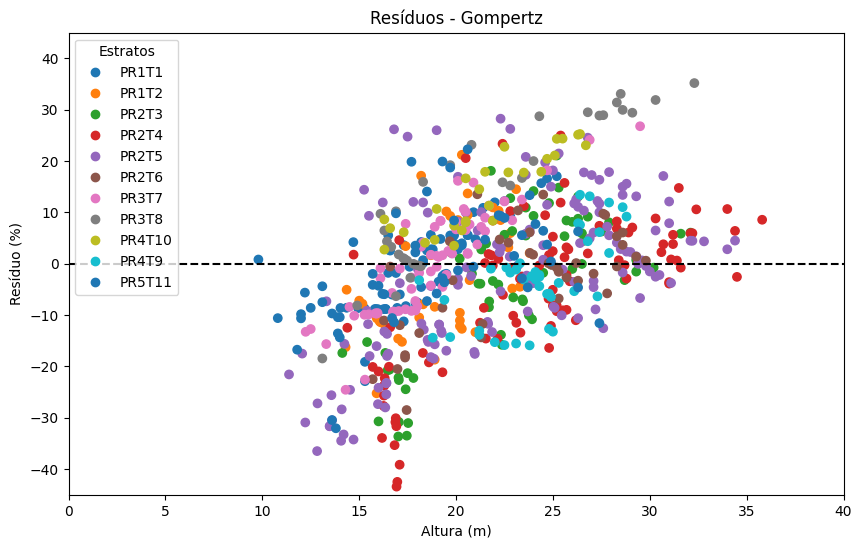

In [ ]:
hip.grafico_residuos(
    modelo="gompertz",            # O modelo 'gompertz' será utilizado para gerar os resíduos
    lista_estratos=None,          # Nenhum estrato específico é filtrado (todos os estratos serão considerados)
    grafico_unico=True,           # Gera um gráfico único contendo os resíduos para todos os estratos
    conjunto_dados="teste"        # O gráfico será gerado com base nos dados do conjunto de teste
)

Gerando gráficos de resíduos individuais para os estratos especificados no parâmetro lista_estratos.

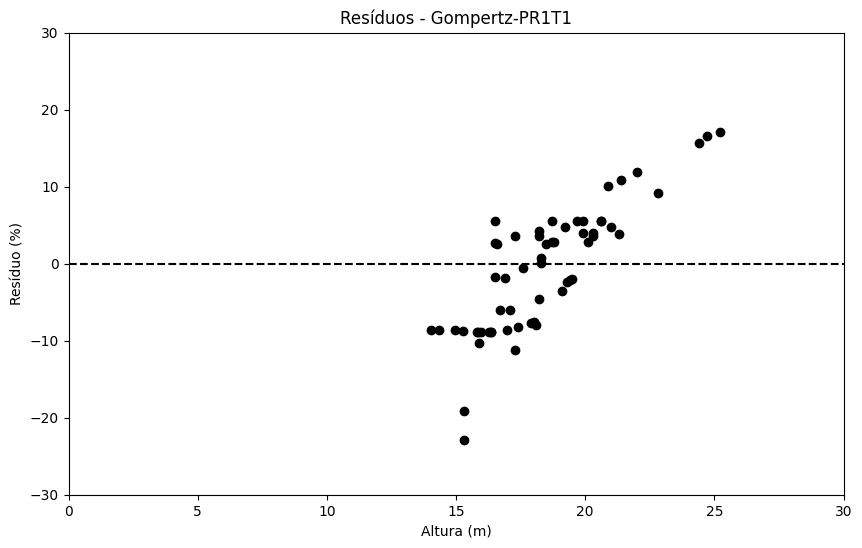

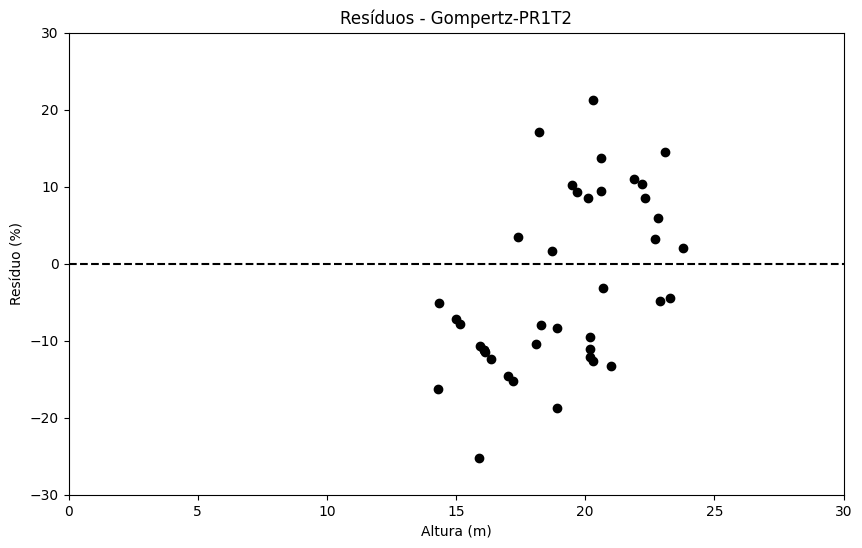

In [ ]:
hip.grafico_residuos(
    modelo="gompertz",  # Modelo utilizado para o cálculo dos resíduos
    lista_estratos=["PR1T1", "PR1T2"],  # Lista de estratos para gerar os gráficos de resíduos
    grafico_unico=False,  # Define que os gráficos serão gerados de forma individual para cada estrato
    conjunto_dados="teste",  # Especifica o conjunto de dados a ser utilizado (teste)
)

In [ ]:
show_doc(EquacoesHipsometricas.grafico_tendencia)

---

### EquacoesHipsometricas.grafico_tendencia

>      EquacoesHipsometricas.grafico_tendencia (modelo:str,
>                                               lista_estratos:list=None,
>                                               conjunto_dados:str=None)

*Gera gráficos de tendência para avaliar o ajuste do modelo de predição de altura*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| modelo | str |  | Nome do modelo utilizado nas predições, como "curtis" ou "logistico". |
| lista_estratos | list | None | Lista de estratos específicos para filtrar os dados. Se None, considera todos os estratos existentes. |
| conjunto_dados | str | None | Identificador do conjunto de dados a ser filtrado, como "treino" ou "teste". Se None, utiliza todos os dados disponíveis. |
| **Returns** | **None** |  |  |

Gerando o gráfico de tendência para os estratos 'PR4T10' e 'PR1T1' utilizando o modelo 'curtis' no conjunto de dados de teste.

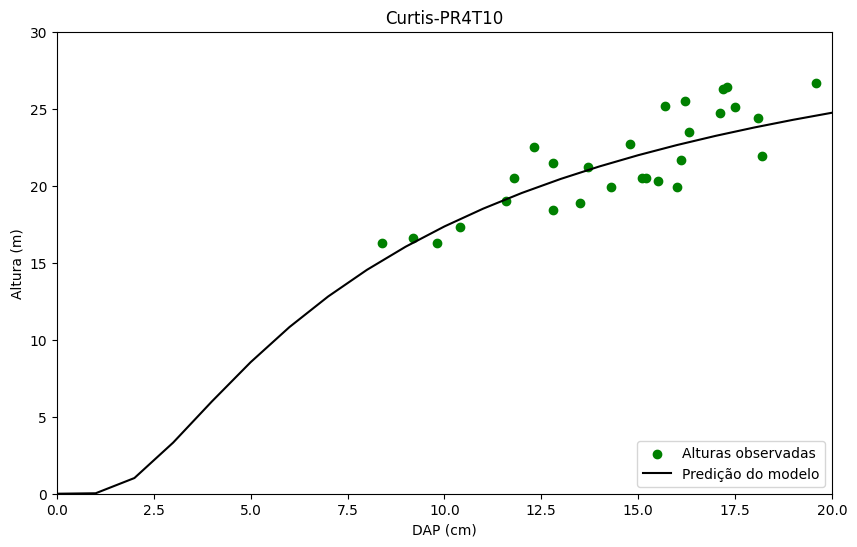

In [ ]:
hip.grafico_tendencia(
    modelo='curtis',  # Especifica o modelo a ser utilizado para gerar a tendência
    lista_estratos=['PR4T10'],  # Define os estratos para os quais o gráfico de tendência será gerado
    conjunto_dados='teste'  # Indica que o gráfico será gerado com os dados de teste
)

In [ ]:
show_doc(EquacoesHipsometricas.grafico_metricas)

---

### EquacoesHipsometricas.grafico_metricas

>      EquacoesHipsometricas.grafico_metricas (lista_estratos:list=None,
>                                              lista_metricas:list=None,
>                                              conjunto_dados:str='teste')

*Gera gráficos para análise de métricas de desempenho do modelo por estrato.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| lista_estratos | list | None | Lista de estratos a serem analisados. Se None, utiliza todos os estratos disponíveis nos dados. |
| lista_metricas | list | None | Lista de métricas a serem plotadas. Se None, considera todas as métricas disponíveis. |
| conjunto_dados | str | teste | Conjunto de dados a ser analisado: "treino" ou "teste". |
| **Returns** | **None** |  |  |

Plotando a comparação entre as métricas RMSE e R² dos modelos para o estrato "PR1T1"

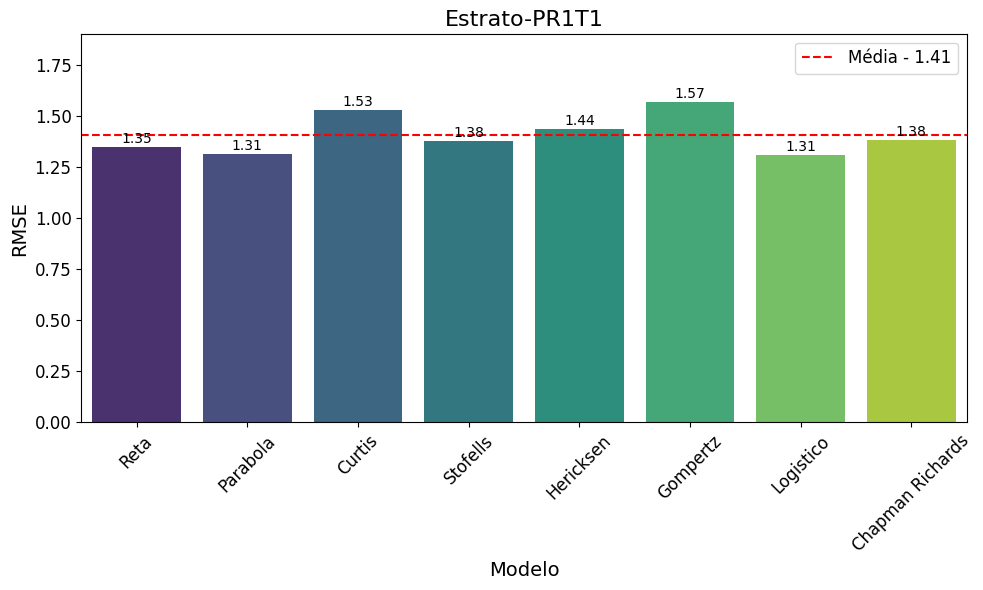

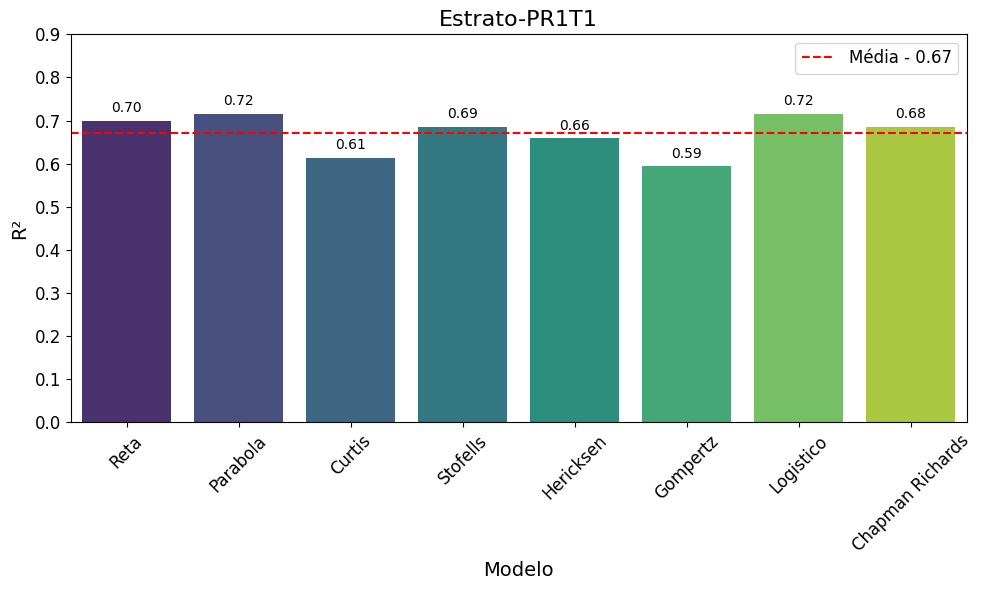

In [ ]:
hip.grafico_metricas(
    lista_estratos=["PR1T1"],  # Lista contendo o estrato para o qual as métricas serão geradas, neste caso "PR1T1".
    lista_metricas=["RMSE", "R²"]  # Lista contendo as métricas que serão comparadas no gráfico, neste caso "RMSE" e "R²".
)

In [ ]:
show_doc(EquacoesHipsometricas.salvar_resultados)

---

### EquacoesHipsometricas.salvar_resultados

>      EquacoesHipsometricas.salvar_resultados ()

*Salva as tabelas principais geradas pelo modelo em arquivos CSV.*

Salvando todas as tabelas localmente

In [ ]:
hip.salvar_resultados()

Arquivos salvos com sucesso.
